# Import Google Drive

In [1]:
#Problemi:
#1) non tutte le immagini hanno una valutazione (good, ok, bad, junk). Queste le ho scartate
#2) molte immagini di dimensione diversa
#3) trovate alcune immagini con label sbagliato

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [2]:
#!unzip "/content/drive/MyDrive/paris.zip" -d "/content/drive/MyDrive/Paris120x120/"  > /dev/null

# Carica i file di Ground Truth

In [3]:
import os

good = set();
ok = set();
bad = set();
junk = set();

#groundtruth_dir = "/content/drive/My Drive/OxfordTxt/"
#groundtruth_dir = "/content/drive/My Drive/gzp/"
groundtruth_dir = r"D:\Andrea\Downloads\gzp"

#Itera i file txt nella directory
def leggi_ground_truth_files(directory):
  for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
      rank = filename.split("_")[-1] #la parte finale del nome del file
      if rank == "good.txt":
        leggi_file(f,good)
      elif rank == "ok.txt":
        leggi_file(f,ok)   
      elif rank == "bad.txt":
        leggi_file(f,bad)
      elif rank == "junk.txt":
        leggi_file(f,junk)
      #elif rank == "query.txt":
        #leggi_file(f,query)
  return;


def leggi_file(f, s):
  with open(f) as f:
    lines = f.readlines()
    for line in lines:
      #rimuovo il \n finale e aggiungo .jpg
      line = line[:len(line)-1] + ".jpg"
      s.add(line)
  return;

In [4]:
leggi_ground_truth_files(groundtruth_dir)
print("Numero di good: ", len(good))
print("Numero di ok: ", len(ok))
print("Numero di bad: ", len(bad))
print("Numero di junk: ", len(junk))

Numero di good:  0
Numero di ok:  1790
Numero di bad:  0
Numero di junk:  1619


# Carica DataSet

In [5]:
from PIL import Image
import numpy as np

class_names = ['paris_defense', 'paris_eiffel', 'paris_general', 'paris_invalides', 'paris_louvre', 'paris_moulinrouge',
                'paris_museedorsay', 'paris_notredame', 'paris_pantheon', 'paris_pompidou', 'paris_sacrecoeur', 'paris_triomphe' ]
num_classes = len(class_names)

#dataset_dir='/content/drive/My Drive/Paris120x120/'
#dataset_dir='/content/drive/My Drive/Paris120x120/'
dataset_dir = r"D:\Andrea\Downloads\Paris120x120"


In [6]:
#Carica il dataset scartando le foto che non hanno una valutazione o ne hanno
#più di una
def carica_dataset_da_directory(dataset_dir):
  #cicla nelle entry della directory
  for filename in os.listdir(dataset_dir):
    f = os.path.join(dataset_dir, filename)
    # checking if it is a file
    if os.path.isfile(f):
      valutazione = carica_valutazione(filename);
      label = carica_label(filename)
      carica_foto(f, dataset, valutazione, label)
  return;


def carica_foto(f, dataset, valutazione, label):
  if label == -1 or valutazione < 0:
    return #foto senza valutazione o senza label, scartata

  img = Image.open(f)
  pix = np.array(img)/255
  if(pix.shape != (120,120,3)): #check sulle dimensioni dell'immagine
    return
  formati.add(pix.shape)
  dataset[label][valutazione].append(pix)
  return;


def carica_label(filename):
  for i in range(len(class_names)):
    if(filename.startswith(class_names[i])):
      return i
  return -1


def carica_valutazione(filename):
  flag = 0
  x = [0,0,0,0] #flag per presenza di filename in good, ok, bad e junk
  if filename in good:
    x[0]=1
  if filename in ok:
    x[1]=1
  if filename in bad:
    x[2]=1
  if filename in junk:
    x[3]=1

  if sum(x) > 1:
    #print(filename, ": valutazioni discordanti")
    return -1
  if sum(x) == 0:
    #print(filename, ": valutazione non disponibile")
    return -2

  for i in range(4):
    if x[i] == 1:
      return i #0:good, 1:ok, 2:bad, 3:junk
  return 0;


#dataset[landmark][valutazione] = foto
dataset = [ [[],[],[],[]] for x in range(len(class_names))] 
formati = set()

carica_dataset_da_directory(dataset_dir)

Funzioni per la stampa di statistiche sul DB

In [7]:
from re import I
#FUNZIONI PER LA STAMPA DI STATISTICHE SUL DB
def dataset_len(dataset):
  n = 0
  for i in range(len(dataset)):
    for j in range(len(dataset[i])):
      n = n + len(dataset[i][j])
  return n;

def immagini_nei_landmark(dataset):
  v = np.zeros(len(dataset))
  for i in range(len(dataset)):
    for j in range(len(dataset[i])):
      v[i] = v[i] + len(dataset[i][j])
  return v;

def valutazioni_landmarks(dataset):
  v = [ [0,0,0,0] for x in range(len(dataset))]
  for i in range(len(dataset)):
    for j in range(len(dataset[i])):
      v[i][j] = len(dataset[i][j])
  return v;

def good_ok_bad_junk(dataset):
  x = valutazioni_landmarks(dataset)
  v = [0,0,0,0]
  for i in range(len(x)):
    for j in range(len(x[i])):
      v[j] = v[j] + x[i][j]
  return v

print("Numero immagini del dataset: ", dataset_len(dataset))
print("Numero di immagini nei vari landmark: ", immagini_nei_landmark(dataset))
print("Per ogni landmark, quanti sono quelli good, ok, bad e junk: ", valutazioni_landmarks(dataset))
print("Immagini good-ok-bad-junk: ", good_ok_bad_junk(dataset))
print("Numero di formati:", len(formati), formati)

Numero immagini del dataset:  3387
Numero di immagini nei vari landmark:  [232. 129. 683. 266. 249. 345.  90. 205. 319. 147. 279. 443.]
Per ogni landmark, quanti sono quelli good, ok, bad e junk:  [[0, 124, 0, 108], [0, 61, 0, 68], [0, 268, 0, 415], [0, 182, 0, 84], [0, 131, 0, 118], [0, 237, 0, 108], [0, 72, 0, 18], [0, 113, 0, 92], [0, 127, 0, 192], [0, 52, 0, 95], [0, 144, 0, 135], [0, 268, 0, 175]]
Immagini good-ok-bad-junk:  [0, 1779, 0, 1608]
Numero di formati: 1 {(120, 120, 3)}


# Split dei dati in training, validation, test set

In [8]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import random

In [9]:
# Da Dataset -> A X_train, X_val, X_test

# per avere uno split equilibrato, esso avverrà secondo il seguente criterio:
# il training set sarà formato, per ogni landmark, dall' 80% del totale delle
# good per quel landmark + 80% del totale delle ok per quel landmark + ecc...
# il test set e il validation set avranno il 10% a testa

def split_dataset(dataset, x_train, x_val, x_test):

  for i in range(len(dataset)):
    for j in range(len(dataset[i])): 
      
      num_samples = len(dataset[i][j])

      train_len = round(0.8 * num_samples)
      x_train[i][j] = x_train[i][j] + dataset[i][j][:train_len]
      
      val_len = (num_samples - train_len) // 2
      x_val[i][j] = x_val[i][j] + dataset[i][j][train_len: train_len + val_len]

      test_len = (num_samples - train_len - val_len)
      x_test[i][j] = x_test[i][j] + dataset[i][j][-test_len:]

  return;

x_train = [ [[],[],[],[]] for x in range(len(class_names))]
x_val = [ [[],[],[],[]] for x in range(len(class_names))]
x_test = [ [[],[],[],[]] for x in range(len(class_names))]

split_dataset(dataset, x_train, x_val, x_test)

print(dataset_len(x_train))
print(dataset_len(x_val))
print(dataset_len(x_test))

2709
334
344


In [10]:
#NON CANCELLARE, SEMPRE UTILE VEDERE COME SI STAMPANO LE IMMAGINI

#def stampa_esempi(val):
#  plt.figure(figsize=(10,10))
#  for i in range(25):
#    plt.subplot(5,5,i+1)
#    plt.xticks([])
#    plt.yticks([])
#    plt.grid(False)
#    #plt.imshow(dataset[i], cmap=plt.cm.binary)
#    landmark = random.randint(0, len(x_train)-1)
#    index = random.randint(0, len(x_train[landmark])-1)
#    plt.imshow(x_train[landmark][val][index], cmap=plt.cm.binary)
#    plt.xlabel(class_names[landmark])
#    if val == 1:
#      plt.ylabel("good")
#    if val == 3:
#      plt.ylabel("junk")
#  plt.show()
#  return;

#Stampa esempi good
#print("Training set examples")
#stampa_esempi(1)
#print("")
#stampa_esempi(3)

# Data Augmentation
 Funzioni per la Stampa

In [11]:
#stampa esempi dato un generatore. Genera 25 foto a partire da un generatore e le visualizza
def print_data_aug(generatore):
    fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(3,3))
    for i in range(5):
        for j in range(5):
            x = next(generatore)
            #print(x[1]) #label y se inserite in datagen.flow(x=...,y=...)
            #image = image[0][0]#.astype('uint8') #immagine se y inserite in datagen.flow(x=...,y=...)
            image = x[0]

            # plot image
            axs[i,j].imshow(image)
            axs[i,j].axis('off')
    return

#stampa le 3 foto di un array tripletta
def stampa_tripletta(tripletta):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10,10))
    for i in range(0,3):
        img = tripletta[i]
        axs[i].imshow(img)
        axs[i].axis('off')
    return

Definizione degli ImageDataGenerator. Gli oggetti ImageDataGenerator definiscono le trasformazioni che si faranno.
Chiamando flow(numpy_array_immagini) su ImageDataGenerator, flow restituirà un generatore di immagini transformate.

In [12]:
#oggetto ImageDataGenerator, definisce le trasformazioni
gen_settings = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=60,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  
    vertical_flip=False,                     
    rescale=None,
    fill_mode='nearest'
)

#ImageDataGenerator senza trasformazioni (forse sarà utile nella fase di test), per ora non usato
test_val_settings = keras.preprocessing.image.ImageDataGenerator()

#da (array_immagini, settings) -> a (generatore di immagini ruotate/zoommate/ecc...)
def transform_array(img_array, datagen):
    generatore = datagen.flow(x=np.asarray(img_array), batch_size=1)
    return generatore

Ora definiamo una classe custom che prende gli ImageDataGenerator del nostro dataset, e gli usa per creare un generatore di triplette.

In [13]:
class CustomDataGenerator(object):
    
    # parametro nel costruttore: dataset_generators. Ha la solita struttura [ [[good],[ok],[bad],[junk]],  [...], ...]
    # però invece che avere le foto nei good, ok, ... ho un generatore per quella categoria che genera le trasformazioni
    
    def __init__(self, dataset_generators, batch_sz=1) -> None:
        self.dataset_generators = dataset_generators
        self.batch_sz = batch_sz
###########################################################################################################################            
#TODO: next_train ritorna una singola tripleta. Sarebbe bello se si usasse batch_sz e ritornasse un batch di triplette
########################################################################################################################### 

    def next_train(self):
        while 1:
            
            random_class = random.randint(0, num_classes-1)
            different_random_class = random.randint(0, num_classes-1)

            while(different_random_class == random_class):
                different_random_class = random.randint(0, num_classes-1)
###########################################################################################################################            
#TODO: Lo [0] torna la prima foto del batch(che è un batch di 1 sola foto). Si potrebbe modificare lavorare su batch più grossi
###########################################################################################################################
            anchor = next(self.dataset_generators[random_class][1])[0] 
            positive = next(self.dataset_generators[random_class][1])[0]
            negative = next(self.dataset_generators[different_random_class][random.choice([1,3])])[0]

            triplet = [anchor, positive, negative]
###########################################################################################################################            
#TODO: RENDERE COMPATIBILE LA TRIPLETA CON L'INPUT DELLA RETE SIAMESE (tipo, transformarla da numpy a tensore, ecc...)
###########################################################################################################################            
            yield(triplet)

x_train, x_val, x_test sono strutture dati di immagini così disposte: [ [[good],[ok],[bad],[junk]],  [...], ...]
Sostituiamo le immagini coi generatori creati a partire da quelle immagini.

In [14]:
#x_train, x_val, x_test prima contenevano array di immagini. Ora contengono generatori separati per classe e qualità
def transform_dataset(ds, gen_settings):
    for i in range(len(ds)):
        for j in [1,3]: #abbiamo solo immagini ok e junk (1 e 3) nel database
###########################################################################################################################            
#TODO: Si può cambiare questo batch_size di 1 e usare batch più grossi
###########################################################################################################################
            generatore = gen_settings.flow(x=np.asarray(ds[i][j]), batch_size=1)
            ds[i][j] = generatore
    return ds

x_train = transform_dataset(x_train, gen_settings)
#x_val = transform_dataset(x_val, test_val_settings)
#x_test = transform_dataset(x_test, test_val_settings)

In [15]:
custom_gen_train = CustomDataGenerator(x_train,1)
generatore_triplete_train = custom_gen_train.next_train()

###########################################################################################################################            
#TODO: Creare un generatore anche per il validation set, che serve al fit_generator del training
###########################################################################################################################

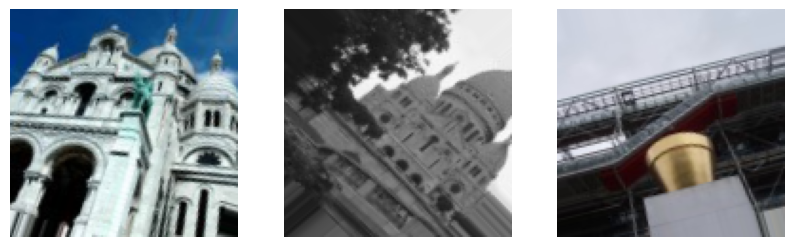

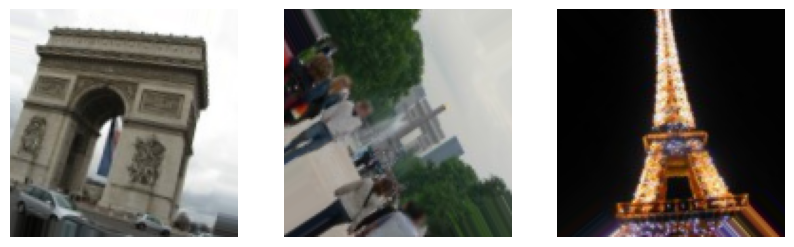

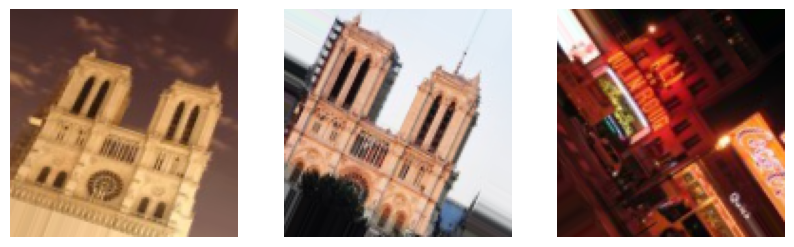

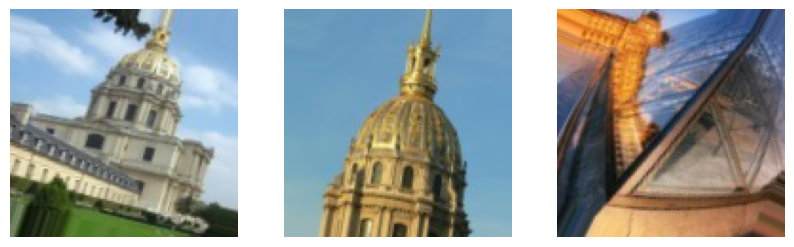

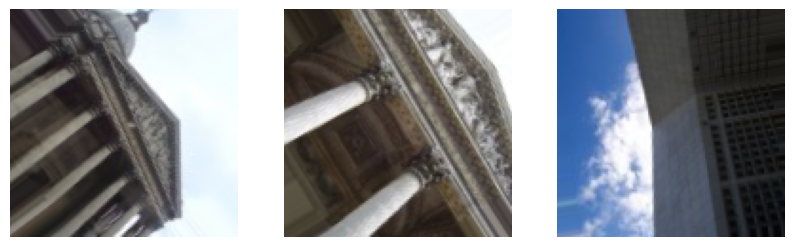

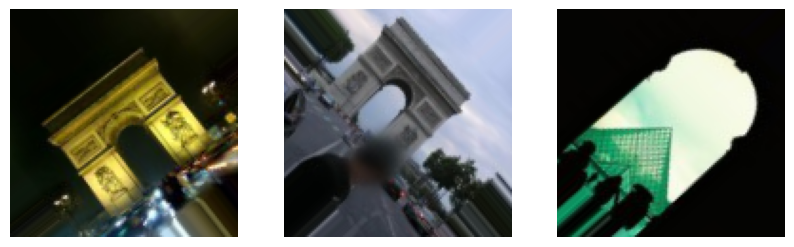

In [20]:
stampa_tripletta(next(generatore_triplete_train))
stampa_tripletta(next(generatore_triplete_train))
stampa_tripletta(next(generatore_triplete_train))
stampa_tripletta(next(generatore_triplete_train))
stampa_tripletta(next(generatore_triplete_train))
stampa_tripletta(next(generatore_triplete_train))

In [18]:
#Prove per capire come funzionano i generatori

#a = [ x_train[0][1][0],] #np vector di 1 sola immagine
#b = [x_train[0][1][1],] #np vector di 1 sola immagine

#a = np.asarray(a)
#b = np.asarray(b)

#generatore1 = transform_array(a,gen_settings) #generatore di immagini trasformate a partire da "a"
#generatore2 = transform_array(b,gen_settings) #generatore di immagini trasformate a partire da "b"

#print_data_aug(generatore1)
#print_data_aug(generatore2)

# Creazione di Coppie

In [3]:
def make_pairs(x):
    """Crea coppie di immagini con label di corrispondenza

    Arguments:
        x è una lista avente la seguente struttura:
          - x[landmark][valutazione][immagine]

    Returns:
        Tuple containing two numpy arrays as (pairs_of_samples, labels),
        where pairs_of_samples' shape is (2len(x), 2,n_features_dims) and
        labels are a binary array of shape (2len(x)).
    """
    pairs = []
    labels = []

    num_classes = len(class_names)

    for i in range(len(x)):
      for j in range(len(x[i])):
        if j == 3:
          continue #salto i junk, non ha senso considerarli come buoni per le coppie
        for z in range(len(x[i][j])):

          # add a matching example
          label1 = i
          x1 = x[i][j][z]
          x2 = random.choice(x[i][1])

          pairs += [[x1, x2]]
          labels += [0]


          # add a non-matching example
          label2 = random.randint(0, num_classes - 1)
          while label2 == label1:
            label2 = random.randint(0, num_classes - 1)
          x2 = random.choice(x[label2][random.choice([1,3])])

          pairs += [[x1, x2]]
          labels += [1]
          
    return np.array(pairs), np.array(labels).astype("float32")

In [4]:
# make train, validation and test pairs
#pairs_train, labels_train = make_pairs(x_train)
#pairs_val, labels_val = make_pairs(x_val)
#pairs_test, labels_test = make_pairs(x_test)

#print(len(pairs_train), len(labels_train))
#print(len(pairs_val), len(labels_val))
#print(len(pairs_test), len(labels_test))

# Creazione Triplet

In [1]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input

def make_triplet(x, preprocess=True):
   #triplets = []
    anchors =[]
    positives=[]
    negatives =[]
    num_classes = len(class_names)

    for i in range(len(x)):
      for j in range(len(x[i])):
        if j == 3:
          continue #salto i junk, non ha senso considerarli come buoni per le coppie
        for z in range(len(x[i][j])):

          # x2 is matching example
          label1 = i
          x1 = x[i][j][z]
          x2 = random.choice(x[i][1])

          # x3 is non-matching example
          label2 = random.randint(0, num_classes - 1)
          while label2 == label1:
            label2 = random.randint(0, num_classes - 1)
          x3 = random.choice(x[label2][random.choice([1,3])])

          #triplets += [[x1, x2, x3]]
          #if preprocess:
          #  x1=preprocess_input(x1)
          #  x2=preprocess_input(x2)
          #  x3=preprocess_input(x3)
          anchors += [x1]
          positives+= [x2]
          negatives+= [x3]

    anchor_dataset = tf.data.Dataset.from_tensor_slices(anchors)
    positive_dataset = tf.data.Dataset.from_tensor_slices(positives)
    negative_dataset = tf.data.Dataset.from_tensor_slices(negatives) 

    return  tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

In [17]:
# make train, validation and test triplet
triplet_train = make_triplet(x_train)
triplet_val = make_triplet(x_val)
triplet_test = make_triplet(x_test)

triplet_train = triplet_train.batch(32, drop_remainder=False)
triplet_train = triplet_train.prefetch(8)

triplet_val = triplet_val.batch(32, drop_remainder=False)
triplet_val = triplet_val.prefetch(8)

#print(len(triplet_train))
#print(len(triplet_val))
#print(len(triplet_test))

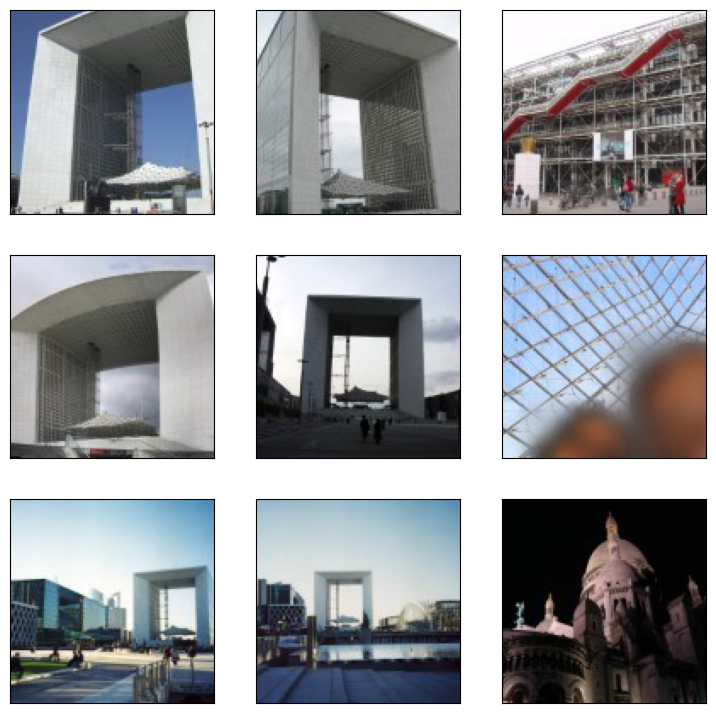

In [15]:
import matplotlib.pyplot as plt

def visualize(an,pos,neg):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], an[i])
        show(axs[i, 1], pos[i])
        show(axs[i, 2], neg[i])

visualize(*list(triplet_train.take(1).as_numpy_iterator())[0])

# Definizione del modello (Binario) (PROVVISORIO)

In [ ]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))


input = layers.Input((120, 120, 3))
x = tf.keras.layers.BatchNormalization()(input)
x = layers.Conv2D(4, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Conv2D(16, (5, 5), activation="tanh")(x)
x = layers.AveragePooling2D(pool_size=(2, 2))(x)
x = layers.Flatten()(x)

x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)


input_1 = layers.Input((120, 120, 3))
input_2 = layers.Input((120, 120, 3))

# As mentioned above, Siamese Network share weights between
# tower networks (sister networks). To allow this, we will use
# same embedding network for both tower networks.
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = layers.Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = tf.keras.layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)



In [ ]:
def loss(margin=1):
    """Provides 'constrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'constrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the constrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing constrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss


In [ ]:
epochs = 10
batch_size = 16
margin = 1  # Margin for constrastive loss.

siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

print(pairs_train.shape)

x_train_1 = pairs_train[:, 0]  # x_train_1.shape is (60000, 28, 28)
x_train_2 = pairs_train[:, 1]

x_val_1 = pairs_val[:, 0]  # x_val_1.shape = (60000, 28, 28)
x_val_2 = pairs_val[:, 1]


print(x_train_1.shape)
print(x_train_2.shape)



In [ ]:
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs,
)


In [ ]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the constrastive loss
plt_metric(history=history.history, metric="loss", title="Constrastive Loss")


# Definizione Modello Triple

In [26]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet import preprocess_input

In [27]:
def get_encoder (input_shape):
    
    base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=input_shape, include_top=False)
    
    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
        
    encode_model = tf.keras.models.Sequential([
        base_cnn,
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(32)
    ], name="Embedding")
    
    
    return encode_model

In [28]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [29]:
def get_siamese_network (input_shape = (120,120,3)):
    embedding_model = get_encoder(input_shape)
    input_anchor = tf.keras.layers.Input(shape= input_shape)
    input_positive = tf.keras.layers.Input(shape= input_shape)
    input_negative = tf.keras.layers.Input(shape= input_shape)
    
    embedding_anchor = embedding_model(resnet.preprocess_input(input_anchor))
    embedding_positive = embedding_model(resnet.preprocess_input(input_positive))
    embedding_negative = embedding_model(resnet.preprocess_input(input_negative))

    #embedding_anchor = embedding_model(input_anchor)
    #embedding_positive = embedding_model(input_positive)
    #embedding_negative = embedding_model(input_negative)

    distances = DistanceLayer()(
    embedding_anchor ,
    embedding_positive,
    embedding_negative ,
    )

    siamese_network =  tf.keras.models.Model(
    inputs=[input_anchor, input_positive, input_negative], outputs=distances
    )
    return siamese_network
    
siamese_network = get_siamese_network()  

In [30]:
class SiameseModel(tf.keras.models.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker =tf.keras.metrics.BinaryAccuracy(name ="accuracy")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        
        with tf.GradientTape() as tape:
            loss,acc = self._compute_loss(data)
        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state((acc|True),acc)
        return {"loss": self.loss_tracker.result(),"acc": self.acc_tracker.result()}

    def test_step(self, data):
        
        loss,acc = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state((acc|True),acc)
        return {"loss": self.loss_tracker.result(),"acc": self.acc_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss, (ap_distance<an_distance)
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker,self.acc_tracker]

In [31]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.00008), weighted_metrics=[])

In [46]:
#history = siamese_model.fit(triplet_train[0], epochs=10, validation_data=triplet_val)
history = siamese_model.fit_generator(generatore_triplete_train, epochs=10, validation_data=triplet_val)
##############################################################################################################################
#TODO:da far funzionare
##############################################################################################################################

C:\Users\Andre\anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


AttributeError: 'PrefetchDataset' object has no attribute 'shape'

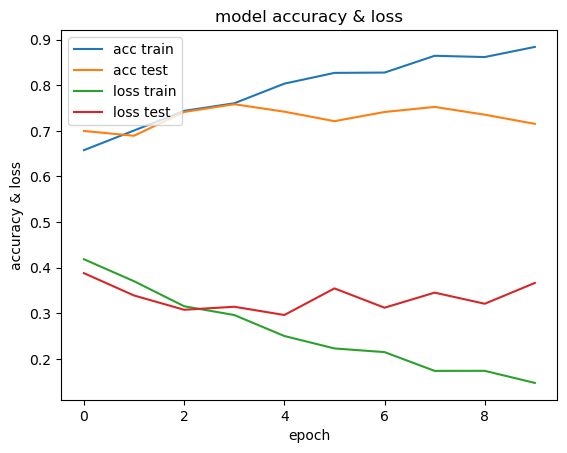

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('accuracy & loss')
plt.xlabel('epoch')
plt.legend(['acc train', 'acc test', 'loss train','loss test'], loc='upper left')
plt.show()

# Usare il modello allenato

Runnare questa cella solo se non si ha il modello "encoder" salvato

In [26]:
def exctract_embedding(model):
    encoder=get_encoder((120,120,3))
    i=0
    for e_layer in model.layers[0].layers[9].layers:
        layer_weight= e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder
encoder=exctract_embedding(siamese_model)
encoder.save_weights("encoder")
encoder.summary()

ResourceExhaustedError: failed to allocate memory [Op:Mul]

Runnare questa cella solo se si sono già calcolati i pesi per il modello "encoder"

In [22]:
encoder=get_encoder((120,120,3))
encoder.load_weights("encoder")

Data un immagine in ingresso, trovare quale immagine appartenente al training set sia la più vicina, e classificare l'immagine in base al graound truth dell'immagine più simile

In [33]:
#Calcolo per ogni immagine del training set l'output attraverso l'encode
def makeX_Y_array (array):
    
    arrT=[] # array di immagini good e ok prese dal parametro 'array'. T sta per Tensor
    y_arrT= [] # array contenente la classe in base all'immagine
    y_levels=[] # y_levels[i] mi indica, per la classe i, l'indice in arrT relativo all'ultimo elemento
                # appartenete a quella classe
    previous=0

    for index in range(len(class_names)):
        #riempiamo arrT
        arrT.extend(array[index][0]) # [i] indica la classe [j] indica la qualita [k] la foto singola
        arrT.extend(array[index][1])

        #riempiamo y_arrT
        totLen=len(array[index][0])+len(array[index][1])
        k=np.zeros(totLen)
        k.fill(index)
        y_arrT.extend(k)
    
        #riempiamo y_levels
        y_levels.append(previous+totLen)
        previous=y_levels[index]
    
    ###################dimezzo i vettori per la poca memoria, da togliere nella versione finale
    #arrT = arrT[0:round(len(arrT)/2)]
    #y_arrT = y_arrT[0:round(len(y_arrT)/2)]

    #conversione in array tensor
    #arrT= tf.data.Dataset.from_tensor_slices(arrT)
    #y_arrT = tf.data.Dataset.from_tensor_slices (y_arrT)
    
    #divisione degli array in batch
    #arrT=arrT.batch(32,drop_remainder=False)
    #y_arrT=y_arrT.batch(32,drop_remainder=False)
    
    return arrT, y_arrT,y_levels

In [24]:
dt,y_train,y_levels = makeX_Y_array(x_train)

In [25]:
points=encoder.predict(dt)

In [26]:
def classify_images(tensor):
    distance = tf.reduce_sum(tf.square(points - tensor), -1)
    return distance

def retrieve_label(tensor): 
    #visto che non è possibile fare y_train[tensore]
    #per ritrovare la classe sottraggo il valore dell'immagine più vicina
    #a y_levels che contiene l'indice dell'ultimo elemento della classe rispetto al dataset in ingresso
    # successivamente trovo tutti i valori maggiori di 0 e ne faccio la somma.
    a=tf.map_fn(lambda x :y_levels-x,tensor) 
    a=tf.cast(tf.math.greater_equal(a,0),tf.int32)  
    a=tf.map_fn(tf.reduce_sum,a)
    #sottraggo la somma con class names e ritrovo l'indice della classe
    a= len(class_names)-a
    return a

class DistanceClassificationLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.points=points

    def call(self, tensor):
        #per ogni immagine vado a calcolare la distanza rispetto a tutti le foto del training set
        predicts = tf.map_fn(classify_images,tensor)
        predicts=tf.argmin(predicts,-1) #prendo l'indice dell'immagine rispetto al training set con la distanza minore
        return retrieve_label(predicts) # ritrovo dall'indice la classe
       
    
       
evaluation_model=tf.keras.models.Sequential([encoder,DistanceClassificationLayer()]) 

Vado a creare un dataset dove (x_test, classi associata)

In [34]:
evaluate_dt,res,re_levels= makeX_Y_array(x_test)
evaluate_dt= tf.data.Dataset.zip((evaluate_dt,res))

TypeError: The argument to `Dataset.zip()` must be a (nested) structure of `Dataset` objects. Python `list` is not supported, please use a `tuple` instead.

In [28]:
#evaluation_model.compile(
#    optimizer='sgd',
#    loss='mse',
    #metrics=[tf.keras.metrics.TopKCategoricalAccuracy()],
#)
    
evaluation_model.compile(metrics=[tf.keras.metrics.CategoricalAccuracy()]) # qui ci andrebbe il topK ma non funziona
evaluation_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Sequential)       (None, 32)                40508064  
_________________________________________________________________
distance_classification_laye (None,)                   0         
Total params: 40,508,064
Trainable params: 25,850,144
Non-trainable params: 14,657,920
_________________________________________________________________


In [29]:
evaluation_model.evaluate(evaluate_dt)

6/6 [==============================] - 3s 350ms/step - loss: 0.0000e+00 - categorical_accuracy: 0.1667


[0.0, 0.1666666716337204]

In [35]:
print(res)
print(len(evaluate_dt), len(evaluate_dt[0]), len(evaluate_dt[0][0]), len(evaluate_dt[0][0][0]))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0]
180 120 120 3


In [31]:
prova = evaluation_model.predict(evaluate_dt)

In [32]:
print(prova)

[ 3  3 11  2  5  0  7 11  3  1  2  0  3  2  2  1  2  3  2 10  2  9  2  0
  1  2 11  3  8  3  3  2 11  3  2  3  2  5  7  7  2 11  7  2  1  3  3  3
  3  2  3  3  3  3  8  0  5 10  1  5  3  3  1 10  7  2  4  7  4  5  3  9
  4  2  3  3 11  5  5  5  3  2  5  4  0  2  2  0  2  8  2  4  5  5  7  5
  2 10  5 11 10  6  9  9  4  6  6  2 11  7 10  9  7  7  1 10 10 11  2 11
  3 10  8  2 10  8  8  8  8  4 11 10  7  3  9  9  2 11  7  3  5 10 10 10
 10  2  0 10 10  3  3  7 10 11  5  3  2  1 11 11 11  5  6  4  5  6 11  1
 11  2  5 10  2 11  3  4  0  0 11  0]
